## Load and prep columns

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


# Define columns
data_columns = ['symbol', 'quoteDate', 'adjustedPrice', 'volume', 'previousClose', 'change', 'changeInPercent', 
                '52WeekHigh', '52WeekLow', 'changeFrom52WeekHigh', 'changeFrom52WeekLow', 
                'percebtChangeFrom52WeekHigh', 'percentChangeFrom52WeekLow', 'Price200DayAverage', 
                'Price52WeekPercChange', '1WeekVolatility', '2WeekVolatility', '4WeekVolatility', '8WeekVolatility', 
                '12WeekVolatility', '26WeekVolatility','52WeekVolatility','4WeekBollingerPrediction', '4WeekBollingerType',
                '12WeekBollingerPrediction', '12WeekBollingerType', 'allordpreviousclose', 'allordchange', 
                'allorddayshigh', 'allorddayslow', 'allordpercebtChangeFrom52WeekHigh', 
                'allordpercentChangeFrom52WeekLow', 'asxpreviousclose', 'asxchange', 'asxdayshigh', 
                'asxdayslow', 'asxpercebtChangeFrom52WeekHigh', 'asxpercentChangeFrom52WeekLow', 'exDividendDate', 
                'exDividendPayout', '640106_A3597525W', 'AINTCOV', 'AverageVolume', 'BookValuePerShareYear', 
                'CashPerShareYear', 'DPSRecentYear', 'EBITDMargin', 'EPS', 'EPSGrowthRate10Years', 
                'EPSGrowthRate5Years', 'FIRMMCRT', 'FXRUSD', 'Float', 'GRCPAIAD', 'GRCPAISAD', 'GRCPBCAD', 
                'GRCPBCSAD', 'GRCPBMAD', 'GRCPNRAD', 'GRCPRCAD', 'H01_GGDPCVGDP', 'H01_GGDPCVGDPFY', 'H05_GLFSEPTPOP', 
                'IAD', 'LTDebtToEquityQuarter', 'LTDebtToEquityYear', 'MarketCap',
                'NetIncomeGrowthRate5Years', 'NetProfitMarginPercent', 'OperatingMargin', 'PE',
                'PriceToBook', 'ReturnOnAssets5Years', 'ReturnOnAssetsTTM', 'ReturnOnAssetsYear', 
                'ReturnOnEquity5Years', 'ReturnOnEquityTTM', 'ReturnOnEquityYear', 'RevenueGrowthRate10Years', 
                'RevenueGrowthRate5Years', 'TotalDebtToAssetsQuarter', 'TotalDebtToAssetsYear', 
                'TotalDebtToEquityQuarter', 'TotalDebtToEquityYear', 'bookValue', 'earningsPerShare', 
                'ebitda', 'epsEstimateCurrentYear', 'marketCapitalization', 'peRatio', 'pegRatio', 'pricePerBook', 
                'pricePerEpsEstimateCurrentYear', 'pricePerEpsEstimateNextYear', 'pricePerSales']

returns = {
    '1': 'Future1WeekReturn',
    '2': 'Future2WeekReturn',
    '4': 'Future4WeekReturn',
    '8': 'Future8WeekReturn',
    '12': 'Future12WeekReturn',
    '26': 'Future26WeekReturn',
    '52': 'Future52WeekReturn',
    '1ra': 'Future1WeekRiskAdjustedReturn',
    '2ra': 'Future2WeekRiskAdjustedReturn',
    '4ra': 'Future4WeekRiskAdjustedReturn',
    '8ra': 'Future8WeekRiskAdjustedReturn',
    '12ra': 'Future12WeekRiskAdjustedReturn',
    '26ra': 'Future26WeekRiskAdjustedReturn',
    '52ra': 'Future52WeekRiskAdjustedReturn'
}

# Load data
raw_data = pd.read_csv('data/companyQuotes-20170417-001.csv')
raw_data.head(5)

/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/neilkloot/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,symbol,quoteDate,lastTradePriceOnly,adjustedPrice,volume,daysHigh,daysLow,previousClose,change,changeInPercent,52WeekHigh,52WeekLow,changeFrom52WeekHigh,changeFrom52WeekLow,percebtChangeFrom52WeekHigh,percentChangeFrom52WeekLow,Price200DayAverage,Price52WeekPercChange,1WeekVolatility,2WeekVolatility,4WeekVolatility,8WeekVolatility,12WeekVolatility,26WeekVolatility,52WeekVolatility,4WeekBollingerBandLower,4WeekBollingerBandUpper,4WeekBollingerPrediction,4WeekBollingerType,12WeekBollingerBandLower,12WeekBollingerBandUpper,12WeekBollingerPrediction,12WeekBollingerType,allordpreviousclose,allordchange,allorddayshigh,allorddayslow,allordpercebtChangeFrom52WeekHigh,allordpercentChangeFrom52WeekLow,asxpreviousclose,asxchange,asxdayshigh,asxdayslow,asxpercebtChangeFrom52WeekHigh,asxpercentChangeFrom52WeekLow,exDividendDate,exDividendPayout,640106_A3597525W,AINTCOV,AverageVolume,Beta,BookValuePerShareYear,CashPerShareYear,DPSRecentYear,EBITDMargin,EPS,EPSGrowthRate10Years,EPSGrowthRate5Years,FIRMMCRT,FXRUSD,Float,GRCPAIAD,GRCPAISAD,GRCPBCAD,GRCPBCSAD,GRCPBMAD,GRCPNRAD,GRCPRCAD,H01_GGDPCVGDP,H01_GGDPCVGDPFY,H05_GLFSEPTPOP,IAD,LTDebtToEquityQuarter,LTDebtToEquityYear,MarketCap,NetIncomeGrowthRate5Years,NetProfitMarginPercent,OperatingMargin,PE,PriceToBook,QuoteLast,ReturnOnAssets5Years,ReturnOnAssetsTTM,ReturnOnAssetsYear,ReturnOnEquity5Years,ReturnOnEquityTTM,ReturnOnEquityYear,RevenueGrowthRate10Years,RevenueGrowthRate5Years,TotalDebtToAssetsQuarter,TotalDebtToAssetsYear,TotalDebtToEquityQuarter,TotalDebtToEquityYear,bookValue,earningsPerShare,ebitda,epsEstimateCurrentYear,marketCapitalization,peRatio,pegRatio,pricePerBook,pricePerEpsEstimateCurrentYear,pricePerEpsEstimateNextYear,pricePerSales,Future1WeekDividend,Future1WeekPrice,Future1WeekReturn,Future1WeekRiskAdjustedReturn,Future2WeekDividend,Future2WeekPrice,Future2WeekReturn,Future2WeekRiskAdjustedReturn,Future4WeekDividend,Future4WeekPrice,Future4WeekReturn,Future4WeekRiskAdjustedReturn,Future8WeekDividend,Future8WeekPrice,Future8WeekReturn,Future8WeekRiskAdjustedReturn,Future12WeekDividend,Future12WeekPrice,Future12WeekReturn,Future12WeekRiskAdjustedReturn,Future26WeekDividend,Future26WeekPrice,Future26WeekReturn,Future26WeekRiskAdjustedReturn,Future52WeekDividend,Future52WeekPrice,Future52WeekReturn,Future52WeekRiskAdjustedReturn
0,CCA,2016-06-30,0.560,0.560,1876700,0.770,0.535,0.765,-0.205,-0.267974,0.56,0.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.560000,0.560000,Steady,Within,0.560000,0.560000,Steady,Within,5221.000000,41.299805,5324.399902,5221.000000,-0.082183,0.083960,5142.399902,39.100097,5247.600098,5142.399902,-0.098884,0.079135,NaN,NaN,108.2,3828.0,NaN,NaN,0.24,-0.213,NaN,NaN,-30.8,NaN,NaN,1.77,0.7426,63500000.0,87.307409,89.957900,87.425456,92.706255,87.037799,85.756318,96.070719,412937.0,1.227102,61.092677,NaN,NaN,NaN,36000000.0,NaN,NaN,-4147.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55,-1.785714,-7.688946,NaN,0.65,16.071429,2.693578,NaN,0.64,14.285714,2.260607,NaN,0.61,8.928571,1.801456,NaN,0.54,-3.571429,-19.327464,NaN,0.56,NaN,NaN,NaN,NaN,NaN,NaN
1,CCA,2016-07-01,0.590,0.590,985000,0.625,0.500,0.515,0.075,0.145631,0.59,0.560,0.000,0.03,0.000000,0.053571,NaN,NaN,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.545000,0.605000,Steady,Within,0.545000,0.605000,Steady,Within,5310.399902,89.399902,5356.500000,5310.399902,-0.066467,0.102520,5233.399902,91.000000,5278.899902,5233.399902,-0.082938,0.098231,NaN,NaN,108.2,3828.0,NaN,NaN,0.24,-0.213,0.0,NaN,-30.8,NaN,NaN,1.77,0.7460,63500000.0,87.307409,89.957900,87.425456,92.706255,87.037799,85.756318,96.070719,412937.0,1.227102,61.092677,NaN,NaN,NaN,36000000.0,NaN,NaN,-4147.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.54,-8.474576,-33.621753,0.0,0.65,10.169492,1.644524,0.0,0.67,13.559322,2.167481,0.0,0.60,1.694915,0.343165,0.0,0.52,-11.864407,-65.4875

-----
Future1WeekReturn


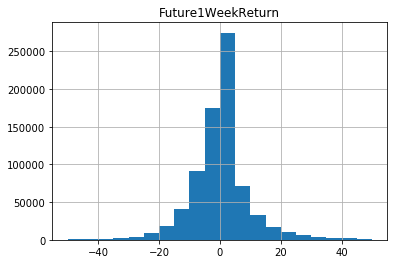

Instances:  771258
Mean:  0.9528324226271839
Min:  -99.92
25th percentile:  -4.166477525538371
Median:  0.0
75th percentile:  3.532008830022078
Max:  49900.0
Std deviation:  104.66549770977275
Variance:  10954.866410834444
Skew:  436.159213561
-----
Future2WeekReturn


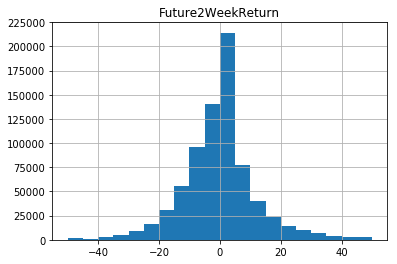

Instances:  768178
Mean:  1.5674015114507465
Min:  -99.96
25th percentile:  -6.245232613447025
Median:  0.0
75th percentile:  5.041693008332588
Max:  49900.0
Std deviation:  139.03169348008464
Variance:  19329.811791940214
Skew:  297.834554507
-----
Future4WeekReturn


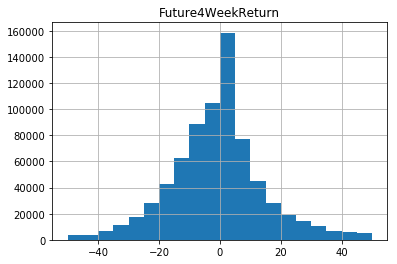

Instances:  763906
Mean:  4.1888037099139845
Min:  -99.96
25th percentile:  -9.22506201958628
Median:  0.0
75th percentile:  7.331410031814271
Max:  756799.988323
Std deviation:  1233.0148875735952
Variance:  1520325.7129781258
Skew:  605.800027354
-----
Future8WeekReturn


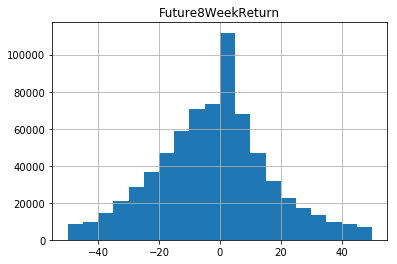

Instances:  756392
Mean:  10.807468561642954
Min:  -99.96
25th percentile:  -14.000238270449735
Median:  -0.3624301395888254
75th percentile:  10.684926885952233
Max:  756799.988323
Std deviation:  2347.7533138441677
Variance:  5511945.6226662705
Skew:  315.554453483
-----
Future12WeekReturn


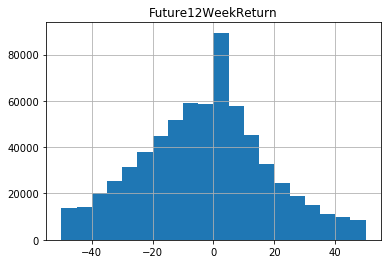

Instances:  747849
Mean:  5.044182765580537
Min:  -99.96
25th percentile:  -17.72727272727273
Median:  -0.9523809523809532
75th percentile:  13.380335005204895
Max:  756799.988323
Std deviation:  887.0880104726973
Variance:  786925.1383244083
Skew:  831.049346497
-----
Future26WeekReturn


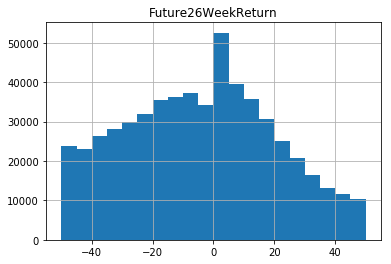

Instances:  719078
Mean:  14.013828354253457
Min:  -99.96
25th percentile:  -29.09090909090909
Median:  -3.124999999999991
75th percentile:  20.138132463997856
Max:  756799.988323
Std deviation:  2367.166778392296
Variance:  5603478.556724161
Skew:  318.149056804
-----
Future52WeekReturn


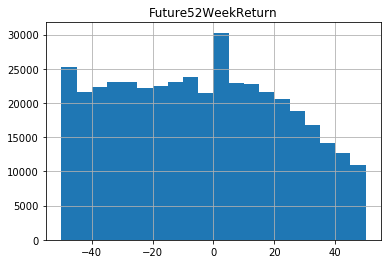

Instances:  673719
Mean:  14.879184180324275
Min:  -99.95
25th percentile:  -44.92753623188405
Median:  -7.6923076923076845
75th percentile:  29.25812356979406
Max:  756799.988323
Std deviation:  1407.3150161334056
Variance:  1980535.5546345678
Skew:  491.273662584
-----
Future1WeekRiskAdjustedReturn


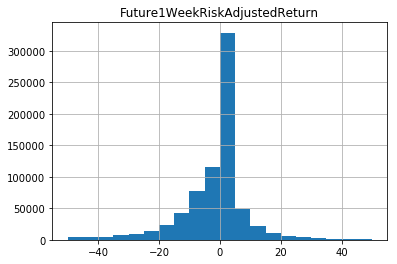

Instances:  771258
Mean:  -78.26455502861815
Min:  -1382846.03289
25th percentile:  -6.832447236429337
Median:  0.0
75th percentile:  1.451068071072563
Max:  49900.0
Std deviation:  4683.006595319819
Variance:  21930550.771808922
Skew:  -187.833491937
-----
Future2WeekRiskAdjustedReturn


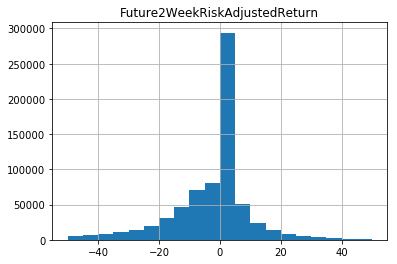

Instances:  768178
Mean:  -165.61464154826493
Min:  -2899932.31611
25th percentile:  -11.538461538461537
Median:  0.0
75th percentile:  1.707451387294313
Max:  49900.0
Std deviation:  8654.449381380411
Variance:  74899494.09487578
Skew:  -163.439223881
-----
Future4WeekRiskAdjustedReturn


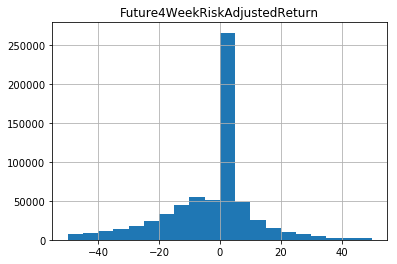

Instances:  763906
Mean:  -342.547933218426
Min:  -3557915.1663
25th percentile:  -20.0
Median:  0.0
75th percentile:  1.9156917902369668
Max:  49900.0
Std deviation:  13984.175239083765
Variance:  195557157.11740348
Skew:  -100.363477268
-----
Future8WeekRiskAdjustedReturn


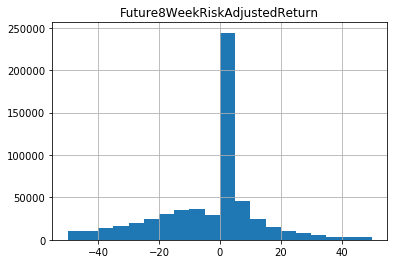

Instances:  756392
Mean:  -727.8327938768274
Min:  -3528491.86758
25th percentile:  -34.436030290952566
Median:  -1.1325528539414425
75th percentile:  2.0855848055549266
Max:  6527.29912007
Std deviation:  24906.255410091584
Variance:  620321558.5527163
Skew:  -80.5384093317
-----
Future12WeekRiskAdjustedReturn


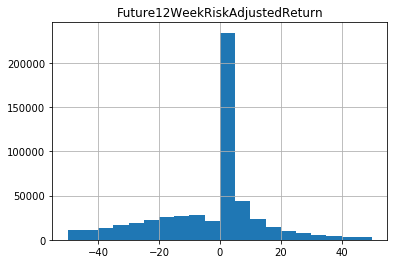

Instances:  747849
Mean:  -1160.2322910315424
Min:  -5821606.61635
25th percentile:  -49.71318323553252
Median:  -2.631578947368428
75th percentile:  2.1381167989637078
Max:  7650.60642153
Std deviation:  36368.59369009342
Variance:  1322674606.9951026
Skew:  -65.2468324392
-----
Future26WeekRiskAdjustedReturn


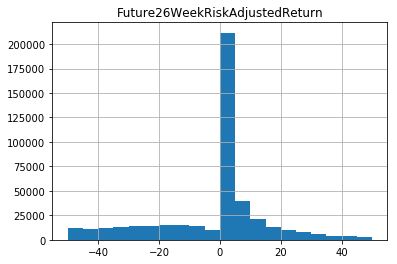

Instances:  719078
Mean:  -2813.661358678318
Min:  -6153055.23285
25th percentile:  -115.86049359504666
Median:  -8.602150537634401
75th percentile:  2.117613272331397
Max:  5192.97417288
Std deviation:  74901.56182584529
Variance:  5610243963.950925
Skew:  -53.4672593881
-----
Future52WeekRiskAdjustedReturn


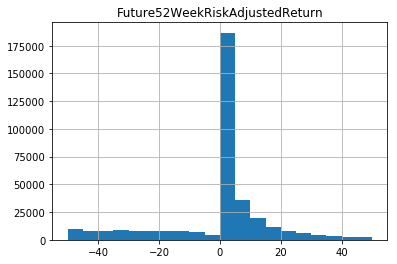

Instances:  673719
Mean:  -6095.747859498521
Min:  -10549910.9918
25th percentile:  -262.7730069628771
Median:  -24.137507452679205
75th percentile:  1.8969033890460054
Max:  5400.0
Std deviation:  153527.54599520273
Variance:  23570707379.309093
Skew:  -46.8673808663


In [2]:
# Plot values for each potential target
for key in returns:
    print('-----')
    return_column = returns[key]
    print(return_column)
    raw_data.hist(column=return_column,bins=[-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 
                                            5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    pyplot.show()


    print('Instances: ', raw_data[return_column].count())
    print('Mean: ', raw_data[return_column].mean())
    print('Min: ', raw_data[return_column].min())
    print('25th percentile: ', raw_data[return_column].quantile(0.25))
    print('Median: ', raw_data[return_column].median())
    print('75th percentile: ', raw_data[return_column].quantile(0.75))
    print('Max: ', raw_data[return_column].max())
    print('Std deviation: ', raw_data[return_column].std())
    print('Variance: ', raw_data[return_column].var())
    print('Skew: ', raw_data[return_column].skew())

In [ ]:
# Check outliers
outliers = raw_data.loc[raw_data['Future8WeekReturn'] > 1000]
print(len(outliers))

exclude_symbols = outliers['symbol'].unique()

In [ ]:
# Remove rows in the excluded symbols list
filtered_data = raw_data[~raw_data['symbol'].isin(exclude_symbols)]


In [ ]:
# Re-plot values for each potential target
for key in returns:
    print('-----')
    return_column = returns[key]
    print(return_column)
    filtered_data.hist(column=return_column,bins=[-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0,
                                                  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    pyplot.show()


    print('Instances: ', filtered_data[return_column].count())
    print('Mean: ', filtered_data[return_column].mean())
    print('Min: ', filtered_data[return_column].min())
    print('25th percentile: ', filtered_data[return_column].quantile(0.25))
    print('Median: ', filtered_data[return_column].median())
    print('75th percentile: ', filtered_data[return_column].quantile(0.75))
    print('Max: ', filtered_data[return_column].max())
    print('Std deviation: ', filtered_data[return_column].std())
    print('Variance: ', filtered_data[return_column].var())
    print('Skew: ', filtered_data[return_column].skew())


In [3]:
# Set target column
target_column = returns['8ra']

# Remove rows missing the target column
filtered_data = raw_data.dropna(subset=[target_column], how='all')

# Create y_data
y_data = filtered_data[target_column].values


# Filter down data to the X columns being used
filtered_data = filtered_data[data_columns]


print(filtered_data.dtypes)

symbol                                object
quoteDate                             object
adjustedPrice                        float64
volume                                 int64
previousClose                        float64
change                               float64
changeInPercent                      float64
52WeekHigh                           float64
52WeekLow                            float64
changeFrom52WeekHigh                 float64
changeFrom52WeekLow                  float64
percebtChangeFrom52WeekHigh          float64
percentChangeFrom52WeekLow           float64
Price200DayAverage                   float64
Price52WeekPercChange                float64
1WeekVolatility                      float64
2WeekVolatility                      float64
4WeekVolatility                      float64
8WeekVolatility                      float64
12WeekVolatility                     float64
26WeekVolatility                     float64
52WeekVolatility                     float64
4WeekBolli

In [4]:
from datetime import datetime as dt
from dateutil.parser import parse

def is_date(string):
    try: 
        parse(string)
        return True
    except:
        return False

def convert_date_to_ordinal(date_val):
    if(pd.isnull(date_val)):
        return -99999
    
    elif(type(date_val) is str):
        if(is_date(date_val)):
            return parse(date_val).toordinal()
        else:
            return -99999

    elif(type(date_val) is int or type(date_val) is float):
        return date_val
    

# Fix date values - convert to ordinals
filtered_data['quoteDate'] = filtered_data['quoteDate'].apply(lambda x: convert_date_to_ordinal(x))

# print(filtered_data['exDividendDate'].apply(lambda x: convert_date_to_ordinal(x)))
filtered_data['exDividendDate'] = filtered_data['exDividendDate'].apply(lambda x: convert_date_to_ordinal(x))

print(filtered_data.head(5))

# Convert categorical variables to boolean fields
#  4WeekBollingerPrediction              
#  4WeekBollingerType                    
#  12WeekBollingerPrediction             
#  12WeekBollingerType                   

filtered_data = pd.get_dummies(data=filtered_data, columns=['symbol', '4WeekBollingerPrediction', '4WeekBollingerType', 
                                                            '12WeekBollingerPrediction', '12WeekBollingerType'])


# Fill nan values with placeholder and check for null values
filtered_data = filtered_data.fillna(-99999)
print(pd.isnull(filtered_data).any())

  symbol  quoteDate  adjustedPrice   volume  previousClose  change  \
0    CCA     736145          0.560  1876700          0.765  -0.205   
1    CCA     736146          0.590   985000          0.515   0.075   
2    CCA     736149          0.590   389500          0.565   0.025   
3    CCA     736150          0.475   288500          0.590  -0.115   
4    CCA     736151          0.575   578900          0.520   0.055   

   changeInPercent  52WeekHigh  52WeekLow  changeFrom52WeekHigh  \
0        -0.267974        0.56      0.560                   NaN   
1         0.145631        0.59      0.560                 0.000   
2         0.044248        0.59      0.560                 0.000   
3        -0.194915        0.59      0.475                -0.115   
4         0.105769        0.59      0.475                -0.015   

   changeFrom52WeekLow  percebtChangeFrom52WeekHigh  \
0                  NaN                          NaN   
1                 0.03                     0.000000   
2          

In [5]:
# Check data types
print(filtered_data.dtypes)

# Copy over X_data columns
X_data = filtered_data.values


# View some sample records
print(X_data[range(0,5)])


quoteDate                              int64
adjustedPrice                        float64
volume                                 int64
previousClose                        float64
change                               float64
changeInPercent                      float64
52WeekHigh                           float64
52WeekLow                            float64
changeFrom52WeekHigh                 float64
changeFrom52WeekLow                  float64
percebtChangeFrom52WeekHigh          float64
percentChangeFrom52WeekLow           float64
Price200DayAverage                   float64
Price52WeekPercChange                float64
1WeekVolatility                      float64
2WeekVolatility                      float64
4WeekVolatility                      float64
8WeekVolatility                      float64
12WeekVolatility                     float64
26WeekVolatility                     float64
52WeekVolatility                     float64
allordpreviousclose                  float64
allordchan

## Run non-optimised xgboost

Training for Future8WeekRiskAdjustedReturn
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Fit elapsed time: 193
Prediction elapsed time: 3
Mean absolute error: 456.680567416


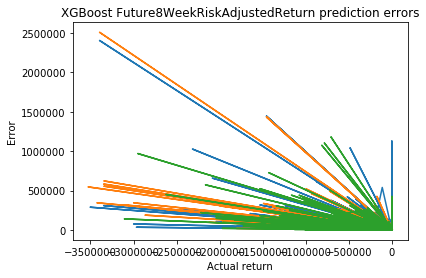

In [23]:
from sklearn.metrics import mean_absolute_error
import time

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

print('Training for', target_column)

# Fit model with training set
model = xgb.XGBRegressor(nthread=-1)
start = time.time()
model.fit(X_train, y_train)
elapsed = time.time() - start

# Output model settings
print(model)
print('Fit elapsed time: %d' % (elapsed))



start = time.time()
# make predictions for test data
predictions = model.predict(X_test)
elapsed = time.time() - start
print('Prediction elapsed time: %d' % (elapsed))

# evaluate predictions
mae = mean_absolute_error(y_test, predictions)
print('Mean absolute error:', mae)

# Evaluate distribution of errors - get error amount for each prediction
y_errors = np.absolute(np.subtract(y_test, predictions))

# Plot the distribution of errors
plot_title = 'XGBoost ' + target_column + ' prediction errors'
pyplot.plot(y_test, y_errors)
pyplot.ylabel('Error')
pyplot.xlabel('Actual return')
pyplot.title(plot_title)
pyplot.show(plot_title)

# ---------- 8 Week Returns ---------------------------------------------
    # --- All data ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  27.209411857320072

    # --- Removed outliers: n_estimators=100 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  23.8139769746

    # --- Removed outliers: n_estimators=200 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=200, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  21.9375376132

    # --- Removed outliers: n_estimators=500 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  21.9761006957

## Basic optimisation

In [20]:
import time

test1 = [5,4,3,2,1]
test2 = [1,1,1,1,2]
subs = np.absolute(np.subtract(test1, test2))
start = time.time()
print(subs)

plot_title = 'XGBoost ' + target_column + ' prediction errors'
print(plot_title)

elapsed = time.time() - start
print('Fit elapsed time: %d' % elapsed)

[4 3 2 1 1]
XGBoost Future8WeekRiskAdjustedReturn prediction errors
Fit elapsed time: 0


## Data checks

In [ ]:
# Check correlations 
filtered_data[data_columns].corr()
